In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

In [2]:
# file csv to panda

nom_du_fichier_csv = '/Users/marche/Documents/Centrale 3A/Apprentissage_Automatique_Project/Python_files/csv_files/train_bdd_clean.csv'
data = pd.read_csv(nom_du_fichier_csv)

nom_du_fichier = "/Users/marche/Documents/Centrale 3A/Apprentissage_Automatique_Project/Python_files/csv_files/pred_retard.csv"
y = data["retard_moyen_tous_trains_arrivee"]
X = pd.read_csv(nom_du_fichier)

# Diviser le jeu de données en ensembles d'entraînement et de test

separation_date = 2023

# Masque pour les données de test (annee == 2023)
test_mask = (data['annee'] == separation_date)

# Masque pour les données d'entraînement (annee < 2023)
train_mask = (data['annee'] < separation_date)

# Séparez les données en ensembles d'entraînement et de test
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

In [7]:
# Créer la pipeline pour les K-plus proches voisins (K-NN) en régression
knn_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())  
])

In [4]:
correlation_matrix = X.corrwith(y)

pd.set_option('display.max_rows', None)
# Afficher la matrice de corrélation
abs_mat = correlation_matrix.abs()

sorted_correlation = abs_mat.sort_values(ascending=False)

print(sorted_correlation)

Distance (km)                             0.169846
Latitude_depart                           0.109289
DEPART_ITALIE                             0.098802
national_service                          0.086960
DEPART_PARIS MONTPARNASSE                 0.069960
ARRIVEE_MARSEILLE ST CHARLES              0.068714
Longitude_arrivee                         0.064434
DEPART_MARSEILLE ST CHARLES               0.058092
DEPART_BARCELONA                          0.055957
nb_train_prevu                            0.052080
ARRIVEE_NANTES                            0.051538
DEPART_CHAMBERY CHALLES LES EAUX          0.050853
DEPART_LYON PART DIEU                     0.048937
DEPART_STRASBOURG                         0.047698
DEPART_PARIS NORD                         0.047050
ARRIVEE_TOURCOING                         0.047004
DEPART_TOULOUSE MATABIAU                  0.042423
ARRIVEE_LILLE                             0.041921
ARRIVEE_MARNE LA VALLEE                   0.041797
DEPART_MADRID                  

9.873630003475922
9.531730386558735
9.443394873858468
9.768963108863758
9.421104582490253
9.344164007650047
9.575796098860508
9.415872237639801
9.60124058741249
30.35977875054968
28.996478811168842
29.03915064823997
24.5122407932759
26.06741186919523
26.590842283071474
28.41917463312048
25.688227887996092
25.848466674871084
24.430407366173785
30.26484101642954
29.198290142525707
30.27384412156291
28.066844830555777
28.38839086543062
27.3752467816267
25.26817022858087
28.16522817125641
25.568751863725055
27.93376556650486
27.164160375976707
28.45167410421685
26.757809139420054
24.259487418894153
29.57846354168729
23.36016299583461
30.65948070105972
26.28124824086387
27.39244464430845
25.273960845090723
29.792031272102008
30.083689881003536
27.39942426905487
27.667956345925585
26.605687916868842
26.50795408204234
24.159574122952414
27.180932683136742
26.865366736179666
29.4087916673603
27.153210638996015
23.43479617131964
26.462608751794683
28.064764609237017
27.614425299477173
27.665503

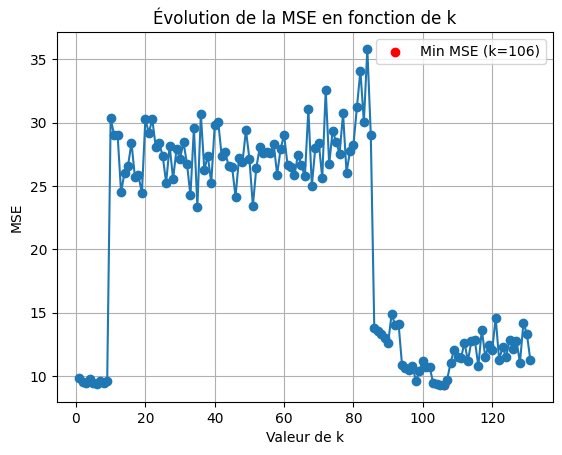

Meilleur k: 106
Meilleure MSE: 9.29772805018956


In [5]:
# Créez des listes pour stocker les scores et les valeurs de k
best_scores = []
best_ks = []
best_mse = np.inf  # Initialisez la meilleure MSE à une valeur maximale

# Créez une liste vide pour stocker les caractéristiques sélectionnées
selected_features = []

# Parcourez les noms de caractéristiques en ordre
for k in range(1, len(X.columns) + 1):
    # Ajoutez le nom de la k-ème caractéristique de sorted_correlation à la liste selected_features
    selected_features.append(sorted_correlation.index[k - 1])

    # Créez la pipeline avec les caractéristiques sélectionnées
    knn_regression_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Étape de mise à l'échelle
        ('regressor', RandomForestRegressor())  # Modèle de régression
    ])

    # Entraînez le modèle avec la pipeline
    knn_regression_pipeline.fit(X_train[selected_features], y_train)

    # Évaluez le modèle en calculant la MSE
    y_pred = knn_regression_pipeline.predict(X_test[selected_features])
    mse = mean_squared_error(y_test, y_pred)

    # Mettez à jour la meilleure MSE et la meilleure valeur de k si nécessaire
    print(mse)
    if mse < best_mse:
        best_mse = mse
        best_k = k

    # Ajoutez la MSE actuelle et la valeur de k aux listes
    best_scores.append(mse)
    best_ks.append(k)

# Créez un graphique de l'évolution de la MSE en fonction de k
plt.figure()
plt.plot(best_ks, best_scores, marker='o')
plt.title("Évolution de la MSE en fonction de k")
plt.xlabel("Valeur de k")
plt.ylabel("MSE")
plt.grid(True)

# Trouvez la valeur de k où la MSE est minimale
min_mse_k = best_ks[np.argmin(best_scores)]
min_mse = min(best_scores)

# Tracez un point à l'emplacement de la MSE minimale
plt.scatter(min_mse_k, min_mse, color='red', label=f'Min MSE (k={min_mse_k})')

# Affichez la légende
plt.legend()

# Affichez le graphique
plt.show()

# Affichez la meilleure valeur de k et la meilleure MSE
print("Meilleur k:", min_mse_k)
print("Meilleure MSE:", min_mse)


In [11]:
knn_regression_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'knn', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Library/Frameworks/Python.framework/Versions/3

Meilleurs hyperparamètres: {'knn__n_neighbors': 44}
Meilleure performance (MSE négatif): 61.87469789173127
Performances de validation croisée (MSE négatif): [ 17.72401194 237.18958361  26.98053256  11.14066086  16.33870049]
Moyenne des performances de validation croisée: 61.87469789173127


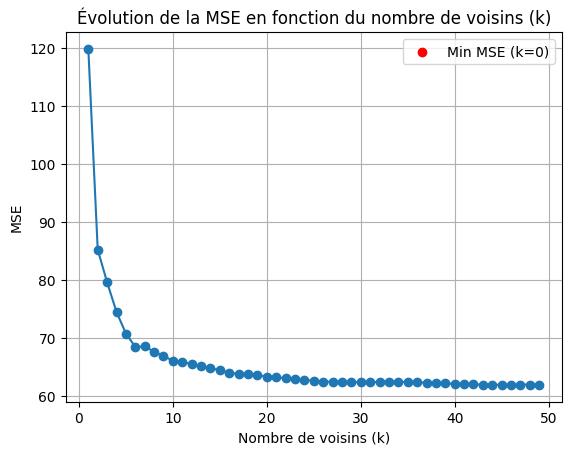

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

# Définissez une grille d'hyperparamètres que vous souhaitez tester pour KNN
param_grid = {
    'knn__n_neighbors': [k for k in range(50)],  # Nombre de voisins

}

best_features = sorted_correlation.index[:min_mse_k]
X_best = X[best_features]


model = knn_regression_pipeline  # Utilisez la pipeline KNN cette fois
print(model)
# Créez l'objet GridSearchCV avec la métrique appropriée (négatif de l'erreur quadratique moyenne)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Effectuez la recherche sur grille en ajustant le modèle aux données
grid_search.fit(X_best, y)

# Obtenez les meilleurs hyperparamètres et la meilleure performance (négatif de l'erreur quadratique moyenne)
best_params = grid_search.best_params_
best_performance = -grid_search.best_score_

# Perform cross-validation on the best model
best_model = grid_search.best_estimator_
cross_val_scores = -cross_val_score(best_model, X_best, y, cv=5, scoring='neg_mean_squared_error')

# Imprimez les résultats
print("Meilleurs hyperparamètres:", best_params)
print("Meilleure performance (MSE négatif):", best_performance)
print("Performances de validation croisée (MSE négatif):", cross_val_scores)
print("Moyenne des performances de validation croisée:", np.mean(cross_val_scores))

# Récupérez les valeurs de k à partir des paramètres
k_values = [params['knn__n_neighbors'] for params in grid_search.cv_results_['params']]
mse_values = -grid_search.cv_results_['mean_test_score']

# Créez un graphique de l'évolution de la MSE en fonction de k
plt.figure()
plt.plot(k_values, mse_values, marker='o')
plt.title("Évolution de la MSE en fonction du nombre de voisins (k)")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("MSE")
plt.grid(True)

# Trouvez la valeur de k où la MSE est minimale
min_mse_k = k_values[np.argmin(mse_values)]
min_mse = min(mse_values)

# Tracez un point à l'emplacement de la MSE minimale
plt.scatter(min_mse_k, min_mse, color='red', label=f'Min MSE (k={min_mse_k})')

# Affichez la légende
plt.legend()

# Affichez le graphique
plt.show()


In [17]:
#on peut appliquer l'elbow method pour choisir le nombre de voisins même si on n'est pas en clustering car il s'agit tout de même d'un bon compromis temps/performance

#on choisit donc k = 5

# Créez la pipeline avec la mise à l'échelle et le modèle knn Regressor en utilisant le meilleur hyperparametre n = nb_voisins
final_knn_pipeline= Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))  
])

final_knn_pipeline .fit(X_train, y_train)
modele_final_mse = mean_squared_error(y_test, final_knn_pipeline .predict(X_test))
print(f"Erreur quadratique moyenne (MSE) du modèle Random Forest en régression : {modele_final_mse:.2f}")

Erreur quadratique moyenne (MSE) du modèle Random Forest en régression : 9.19
